# import

In [125]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [126]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [127]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 0. Overview

* In the last tutorial we used a RNN to classify names into their language of origin. This time we'll turn around and generate names from languages.
* The big difference is instead of predicting a category after reading in all the letters of a name, we input a cetegory and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a "language model".

# 1. Preparing the Data

In [128]:
def find_files(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
# print(all_letters)
# print(n_letters)
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# Read a file and split into lines
def read_lines(fname):
    lines = open(fname, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [129]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
for fname in find_files('/content/drive/MyDrive/ICE3050/dataset/names/*.txt'):
    category = os.path.splitext(os.path.basename(fname))[0]
    all_categories.append(category) # country name
    lines = read_lines(fname)
    category_lines[category] = lines

n_categories = len(all_categories)
n_categories

18

In [130]:
print(all_categories[:5])
print(category_lines['English'][:5])

['Polish', 'Irish', 'Greek', 'French', 'Korean']
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


# 2. Creating the Network

* This network extends the last tutorial's RNN with an extra argument for the category tensor, which is concatenated along with the otehrs. The category tensor is a one-hot vector just like the letter input.

* We will interpret the output as the probability of the next letter. When sampling, the most liekly output letter is used as the next input letter.

![link text](https://i.imgur.com/jzVrf7f.png)

마지막 hidden -> out combined 으로 가는 연결 선은 잘모 ㅅ그리심ㅁ

* **Q.1**: 3 points (1 point, 2 points)

In [131]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        ############################################################################
        # TODO: implement an __init__ function of RNN. This class has five member  #
        # variables: hidden_size, num_layers, rnn, fc, and dropout, Assign suitable#
        # values to all of those variables. IMPORTANT: (1) do "not" use nn.Linear  #
        # to implement self.rnn, please use nn.RNN instead. (2) a probability of an#
        # element to be zeroed (the first argument of Dropout layer) is 0.1.       #
        ############################################################################
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True) #linear 사용하지 말고 내장 rnn
        self.fc = nn.Linear(hidden_size,output_size)
        self.dropout = nn.Dropout(p=0.1) #nn.Module dropout -> dropout 비욜 0.1로 
        # ********** END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) *********** #

    def forward(self, category, input, hidden=None):
        ############################################################################
        # TODO: implement a forward function. This function outputs two tensors    #
        # (output, hidden), where the first one is the final output of self.fc()   #
        # and the second one is the final hidden state of self.rnn(). You're answer#
        # MUST include all of the following:                                       #
        #     (1) initialize hidden state, if hidden is None.                      #
        #     (2) concatenate two input tensors (category, input).                 #
        #     (3) forward propagate through self.rnn (nn.RNN module).              #
        #     (4) reshape the output to fit self.fc (nn.Linear module).            #
        #     (5) forward propagate through self.fc (nn.Linear module).            #
        #         (the input to self.fc is the output of the self.nn)              #
        #     (6) dropout some elements of the output of self.fc()                 #
        ############################################################################

        if hidden is None:
            hidden = self._init_hidden().to(device)#1
        
        combined=torch.cat((category,input),2)
        output,hidden=self.rnn(combined)
        output=self.fc(output.reshape(len(output),-1))
        output=self.dropout(output)

        # ********** END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) *********** #
        return output, hidden
    
    def _init_hidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)

# 3. Training

### 3.1. Preparing for Training

* Helper functions to get random pairs of (category, line)

In [132]:
# random item from a list
def random_choice(lst):
    return lst[random.randint(0, len(lst)-1)]

# get a random category and random line from that category
def random_training_pair(all_categories, category_lines):
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    # print(category,line)
    return category, line

* For each timestep (that is, for each letter in a training word) the inputs of the network will be (```category```, ```current letter```, ```hidden state```) and the outputs will be (```next letter```, ```next hidden state```). So for each training set, we'll need the category, a set of input letters, and a set of output/target letters.

* Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for ```"ABCD<EOS>"``` we would create ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS").

![link text](https://i.imgur.com/JH58tXY.png)

* The category tensor is a one-hot tensor of size ```<1 x n_categories>```. When training we feed it to the network at every timstep.

* **Q.2**: 3 points (1 point each)

In [133]:
# One-hot matrix for category
def category_tensor(category, line_length, n_categories):
    tensor = torch.zeros(line_length, 1, n_categories)
    ################################################################################
    # TODO: implement a function that takes as input a string (category value), the#
    # length of a line, the number of categories and convert the category value    #
    # into a one-hot matrix of size (line_length, 1, n_categories). For example, if#
    # the input is "Arabic", then the output is [[1, 0, ..., 0], [1, 0, ..., 0], ..#
    # .., [1, 0, ..., 0]]. All row vectors are the same, and all the values of each#
    # row vector are zero except i'th position, where i is the index of "Arabic" in#
    # all_categories variable. Since the index of "Arabic" in the all_categories   #
    # is 0, only the 0'th element of each row vector is one.                       #
    ################################################################################
    li = all_categories.index(category)
    for v in tensor:
        v[0][li] = 1
    # ************ END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ************* #
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def input_tensor(line, line_length, n_letters):
    tensor = torch.zeros(line_length, 1, n_letters)
    ################################################################################
    # TODO: implement a function that takes as input a string (line; a single last #
    # name) and convert it into a one-hot matrix of size (len(line), 1, n_letters).#
    # For example, if the input is "abc", then the output should be [[1, 0, 0, ...]#
    # , [0, 1, 0, ...], [0, 0, 1, 0, ...]].                                        #
    ################################################################################
    for idx,v in enumerate(tensor):
        v[0][all_letters.find(line[idx])] = 1
    # ************ END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ************* #
    return tensor

# LongTensor of second letter to end (EOS) for target
def target_tensor(line, line_length, n_letters):
    ################################################################################
    # TODO: implement a function that intakes a string (line; the last name) and   #
    # convert ecah chracter in the string from the second element (index==1) into  #
    # the index that points the location of the same character in the all_letters  #
    # variable. For example, if the input is "abc", then the output should be      #
    # [1, 2, n_letters-1]. Since we convert the character from the second (not the #
    # first) element, the index of "a" (0) is not included in the list. Note that  #
    # you MUST add the number (=n_letters-1) at the back of the list, which        #
    # indicates the End of Sentence (EOS). Please refer to the figure above.       #
    ################################################################################
    letter_indices=[all_letters.find(line[li]) for li in range(1,line_length)]
    letter_indices.append(n_letters-1)
    # ************ END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ************* #
    return torch.LongTensor(letter_indices)

* **Q.3**: 1 point

In [134]:
# Make category, input, and target tensors from a random category, line pair
def random_sample(all_categories, category_lines, n_categories, n_letters):
    ##########################################################################
    # TODO: implement a sampling function. This function (1) randomly sample #
    # a training pair (category, line), (2) convert the category into one-hot#
    # matrix, (3) convert the line into one-hot matrix (the input tensor),   #
    # and (4) convert the line into a 1d vector of indices (the ground truth #
    # tensor). Plese use the implemented functions (random_training_pair,    #
    # category_tensor, input_tensor, target_tensor).                         #
    ##########################################################################
    category,line=random_training_pair(all_categories,category_lines)
    line_length=len(line)
    category_t=category_tensor(category,line_length, n_categories)
    input_line_t=input_tensor(line,line_length,n_letters)
    target_line_t=target_tensor(line,line_length,n_letters)

    # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********** #
    return category_t, input_line_t, target_line_t

### 3.2. Training the Network

* In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

* **Q.4**: 1 point

In [135]:
def train(model, all_categories, category_lines, epochs, lr, log_every):
    # set seed
    torch.manual_seed(444)
    # ship to cuda
    model.to(device)
    # loss
    loss_fn = nn.CrossEntropyLoss()
    # optimizer
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    # step function
    def one_step(category_t, input_line_t, target_line_t):
        ##########################################################################
        # TODO: implement a step function. You're answer MUST include all of the #
        # following:                                                             #
        #     (1) forward propagate                                              #
        #     (2) compute cross-entropy loss                                     #
        #     (3) set all gradients zero                                         #
        #     (4) backward propagate                                             #
        #     (5) update parameters                                              #
        ##########################################################################
        
        output,hidden=model(category_t,input_line_t) #1
        loss=loss_fn(output,target_line_t) #2
        optim.zero_grad() #3
        loss.backward() #4 
        optim.step() #5
        
        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********** #
        return loss.item()
    
    current_loss, losses = 0, []

    # main loop
    for e in tqdm(range(1, epochs+1)):
        # get sample data
        category_t, input_line_t, target_line_t = random_sample(
            all_categories, category_lines, n_categories, n_letters
        )
        # ship to cuda
        category_t = category_t.to(device)
        input_line_t = input_line_t.to(device)
        target_line_t = target_line_t.to(device)
        # one step forward & backward
        loss = one_step(category_t, input_line_t, target_line_t)
        # acuumulate loss
        current_loss += loss
        if e % log_every == 0:
            current_loss /= log_every
            print(f"Epoch: {e}/{epochs}, Loss; {current_loss:.4f}")
            losses.append(current_loss)
            current_loss = 0
    
    return losses

In [136]:
hidden_size = 128
input_size = n_categories + n_letters
rnn = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, output_size=n_letters)

In [137]:
losses = train(rnn, all_categories, category_lines, epochs=100000, lr=4e-5, log_every=5000)

  5%|▌         | 5097/100000 [00:10<03:01, 521.88it/s]

Epoch: 5000/100000, Loss; 3.2164


 10%|█         | 10055/100000 [00:20<02:59, 500.78it/s]

Epoch: 10000/100000, Loss; 2.8656


 15%|█▌        | 15059/100000 [00:29<02:49, 501.99it/s]

Epoch: 15000/100000, Loss; 2.8114


 20%|██        | 20098/100000 [00:39<02:38, 505.48it/s]

Epoch: 20000/100000, Loss; 2.7284


 25%|██▌       | 25069/100000 [00:50<02:24, 517.74it/s]

Epoch: 25000/100000, Loss; 2.6581


 30%|███       | 30104/100000 [01:01<02:16, 510.45it/s]

Epoch: 30000/100000, Loss; 2.6201


 35%|███▌      | 35094/100000 [01:15<02:23, 452.25it/s]

Epoch: 35000/100000, Loss; 2.5931


 40%|████      | 40000/100000 [01:27<02:23, 417.36it/s]

Epoch: 40000/100000, Loss; 2.5643


 45%|████▌     | 45030/100000 [01:38<01:58, 462.93it/s]

Epoch: 45000/100000, Loss; 2.5511


 50%|█████     | 50090/100000 [01:48<01:35, 522.84it/s]

Epoch: 50000/100000, Loss; 2.5246


 55%|█████▌    | 55087/100000 [01:58<01:28, 508.21it/s]

Epoch: 55000/100000, Loss; 2.5122


 60%|██████    | 60056/100000 [02:08<01:17, 514.12it/s]

Epoch: 60000/100000, Loss; 2.5093


 65%|██████▌   | 65054/100000 [02:19<01:09, 502.56it/s]

Epoch: 65000/100000, Loss; 2.4839


 70%|███████   | 70060/100000 [02:29<00:57, 521.72it/s]

Epoch: 70000/100000, Loss; 2.4836


 75%|███████▌  | 75076/100000 [02:39<00:48, 515.91it/s]

Epoch: 75000/100000, Loss; 2.4767


 80%|████████  | 80064/100000 [02:49<00:39, 499.95it/s]

Epoch: 80000/100000, Loss; 2.4718


 85%|████████▌ | 85070/100000 [02:59<00:29, 513.95it/s]

Epoch: 85000/100000, Loss; 2.4653


 90%|█████████ | 90066/100000 [03:09<00:19, 516.14it/s]

Epoch: 90000/100000, Loss; 2.4762


 95%|█████████▌| 95066/100000 [03:19<00:09, 512.15it/s]

Epoch: 95000/100000, Loss; 2.4592


100%|██████████| 100000/100000 [03:29<00:00, 477.78it/s]

Epoch: 100000/100000, Loss; 2.4476


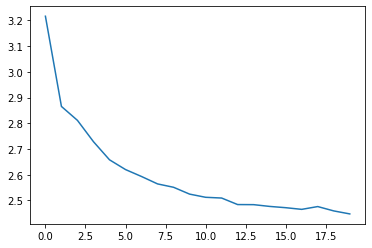

In [138]:
plt.plot(losses)

# 4. Sampling the Network

To generate a word we give the networka letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

* Create tensors for input category, starting letter, and empty hidden state
* Create a string ```output_name``` with the starting letter
* **Q.5** (2 points): Up to a maximum output length (**you shoud implement from here**)
    1. Feed the current letter to the network
    2. Get the next letter from highest output, and next hidden state.
    3. If the letter is EOS, stop here
    4. If a regular letter, add to ```output_name``` and continue.
* Return the final name

In [139]:
def sample(model, category, start_letter):
    max_length = 20
    with torch.no_grad():
        category_t = category_tensor(category, len(start_letter), n_categories)
        input_t = input_tensor(start_letter, len(start_letter), n_letters)
        hidden = model._init_hidden()
        output_name = start_letter
        for i in range(max_length):
            ############################################################################
            # TODO: implement a text generating function. Up to a maximum output length#
            #      (1) Feed the current letter to the network                          #
            #      (2) Get the next letter from highest output, and next hidden state  #
            #      (3) If the letter is EOS, stop here                                 #
            #      (4) If a regular letter, add to output_name and continue            #
            ############################################################################
            output,hidden=model(category_t,input_t,hidden)
            v,i=output.topk(1)
            i=i[0,0]
            if i==n_letters-1:
                break
            output_name+=all_letters[i]
            category_t=category_tensor(category,len(output_name),n_categories)
            input_t=input_tensor(output_name,len(output_name),n_letters)
            # ********** END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) *********** #
        return output_name
    
def samples(model, category, start_letters):
    for start_letter in start_letters:
        print(sample(model, category, start_letter))

In [140]:
rnn = rnn.to('cpu')

In [141]:
samples(rnn, 'Russian', 'RUS')
samples(rnn, 'Chinese', 'CHI')

Rov
Uring
Shin
Chi
Han
In


In [142]:
drive.flush_and_unmount()